### Content Analysis Political Party
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("Topics_FB_Political_Posts_per_partyimmigration_random.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(251, 35)

In [5]:
posts['URL']

0      https://www.facebook.com/LatinosForTrump/posts...
1      https://www.facebook.com/LatinosForTrump/posts...
2      https://www.facebook.com/RealLft2020/posts/179...
3      https://www.facebook.com/Latinos4Biden/posts/1...
4      https://www.facebook.com/groups/17457134490857...
                             ...                        
246    https://www.facebook.com/groups/16117025857872...
247    https://www.facebook.com/groups/16117025857872...
248    https://www.facebook.com/groups/16117025857872...
249    https://www.facebook.com/groups/37168613350092...
250    https://www.facebook.com/groups/51248309636472...
Name: URL, Length: 251, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-09-06 11:03:27 EDT
1    2020-09-14 09:39:35 EDT
2    2020-09-21 01:28:11 EDT
3    2020-10-23 11:27:26 EDT
4    2020-08-29 14:08:11 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-09-06 11:03:27-04:00
1     2020-09-14 09:39:35-04:00
2     2020-09-21 01:28:11-04:00
3     2020-10-23 11:27:26-04:00
4     2020-08-29 14:08:11-04:00
                 ...           
246   2020-10-14 18:45:36-04:00
247   2020-11-03 11:25:28-05:00
248   2020-10-16 20:57:07-04:00
249   2020-09-02 13:54:11-04:00
250   2020-10-30 08:58:55-04:00
Name: converted_date, Length: 251, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date'] = posts['converted_date'].dt.date

In [62]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date

,converted_date,count
0,2020-08-18,6
1,2020-08-19,4
2,2020-08-20,3
3,2020-08-21,1
4,2020-08-22,2
5,2020-08-23,1
6,2020-08-24,2
7,2020-08-25,2
8,2020-08-28,1
9,2020-08-29,1


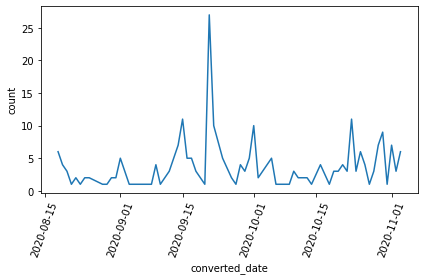

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')

plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [17]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Latinos Against Donald Trump,25
Latinos For Trump -California Group,22
Latinos For Trump.,15
Mexicans for Donald Trump,14
CARA - Cuban American Republican Alliance,11
...,...
American Latinos for freedom! Trump 2020,1
Latinos For Trump Wisconsin,1
Latinos For Trump en Espaol,1


In [18]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (105, 36)
republicans (158, 36)
general politics (5, 36)
none (61,)


35

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [19]:
posts_democrats['MessageDescr'][3:6]

12     According to the “virtuous” Democrats that cr...
14    Ilhan Omar you are a Fraud corrupted criminal!...
21     The difference between me and a lot of my Dem...
Name: MessageDescr, dtype: object

In [20]:
posts_democrats.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party', 'converted_date'],
      dtype='object')

## FB Groups Political Posts

## Tokenize words and Clean-up text

In [21]:
content = posts.copy()
content['MessageDescr']

0      "President Donald J. Trump is bringing back th...
1      President Donald J. Trump: "Our Hispanic-Ameri...
2      Since 2016, Julio de Lima Silva, originally fr...
3      There you go! That man lies, lies, lies. https...
4      “ I raise a Hallelujah, in the presence of my ...
                             ...                        
246    Not yet Eligible to Vote? Your 'adopted' Count...
247     US Judge Blocks Trump Immigration Rule on Pub...
248    Trump could change our Representatives, for ye...
249     IS TRUMP RIGHT?\n.\nDONALD TRUMP: 'NOT ONE EU...
250    They need to do their homework and it's not ab...
Name: MessageDescr, Length: 251, dtype: object

In [22]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(251,)

In [23]:
# Convert to list
data = content.cleanMessage.tolist()

In [24]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['president', 'donald', 'trump', 'is', 'bringing', 'back', 'the', 'pharmaceutical', 'industry', 'to', 'puerto', 'rico', 'after', 'democrats', 'like', 'joe', 'biden', 'sent', 'our', 'jobs', 'to', 'communist', 'china', 'juan', 'carlos', 'benitez', 'entrepreneur', 'immigration', 'attorney', 'latinosfortrump'], ['president', 'donald', 'trump', 'our', 'hispanic', 'american', 'population', 'wants', 'legal', 'immigration', 'latinosfortrump']]


#### Creating Bigram and Trigram Models

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['president', 'donald', 'trump', 'is', 'bringing', 'back', 'the', 'pharmaceutical', 'industry', 'to', 'puerto', 'rico', 'after', 'democrats', 'like', 'joe_biden', 'sent', 'our', 'jobs', 'to', 'communist', 'china', 'juan_carlos', 'benitez', 'entrepreneur', 'immigration', 'attorney', 'latinosfortrump']


## Remove Stopwords, Make Bigrams and Lemmatize

In [27]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [28]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [30]:
print(data_words_nostops[1:2])

[['president', 'donald', 'trump', 'hispanic', 'american', 'population', 'wants', 'legal', 'immigration', 'latinosfortrump']]


## Bag of Words

In [31]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [32]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [33]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [34]:
final_dict.most_common(1000)

[('trump', 247),
 ('american / america', 74),
 ('votar', 43),
 ('country', 35),
 ('also', 32),
 ('mexico', 31),
 ('reform', 28),
 ('democrats', 23),
 ('citizen', 22),
 ('political', 21),
 ('originally', 20),
 ('border', 20),
 ('brazil', 19),
 ('justice', 19),
 ('legal', 19),
 ('first_presidential', 18),
 ('federalist_latinos', 18),
 ('talk', 18),
 ('losar', 17),
 ('national', 16),
 ('federal', 16),
 ('criminal', 14),
 ('director', 14),
 ('law', 14),
 ('president / presidente', 14),
 ('really', 13),
 ('placer', 13),
 ('ideo', 13),
 ('medio', 13),
 ('didnt', 13),
 ('race', 12),
 ('choose', 12),
 ('nurse', 12),
 ('coronavirus', 12),
 ('illegal', 11),
 ('states', 11),
 ('immigration', 11),
 ('social', 11),
 ('campaign', 10),
 ('global', 10),
 ('decir', 10),
 ('latinosfortrump', 9),
 ('order', 9),
 ('regional', 9),
 ('individual', 9),
 ('create', 9),
 ('armar', 9),
 ('dictator', 8),
 ('want_someone', 8),
 ('simple', 8),
 ('sexual', 8),
 ('college', 8),
 ('two', 8),
 ('fear', 8),
 ('alone', 

In [35]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [36]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
print(bow_df)

     abide  able  abogar  abril  abusar  abuso  acceso  access  account  \
0        0     0       0      0       0      0       0       0        0   
1        0     0       0      0       0      0       0       0        0   
2        0     0       0      0       0      0       0       0        0   
3        0     0       0      0       0      0       0       0        0   
4        0     0       0      0       0      0       0       0        0   
..     ...   ...     ...    ...     ...    ...     ...     ...      ...   
246      0     0       0      0       0      0       0       0        0   
247      0     0       0      0       0      0       0       0        0   
248      0     0       0      0       0      0       0       0        0   
249      0     0       0      0       0      0       0       0        0   
250      0     0       0      0       0      0       0       0        0   

     accountable  ...  vulnerable  want_someone  way  website  words  worse  \
0              0  ..

In [37]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [38]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,1.914309
america,2.768229
country,3.095442
votar,3.095442
reform,3.162133
...,...
former,5.836282
forzoso,5.836282
foundation,5.836282
fetched,5.836282


In [39]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [40]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [41]:
df

,tfidf
democrats,0.684108
latinosfortrump,0.729381


In [42]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,still love my democrat friends and family but...,2
1,"born in colombia, #latinosfortrump advisory b...",2
2,"president donald j. trump: ""our hispanic-amer...",1
3,"""president donald j. trump is bringing back th...",1
4,"president donald j. trump: ""our hispanic-ameri...",1
5,"""president donald j. trump is bringing back t...",1
6,we as latino american voted for president tru...,1


### Repeated messages

In [43]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [44]:
results.sort_values(by='Counts',ascending=False)

Counts  \
MessageDescr                                       Link                                                         
 Since 2016, Julio de Lima Silva, originally fr... https://www.facebook.com/RealLft2020/videos/358...      18   
 Do you know Alexander Hamilton? Would you like... https://www.facebook.com/laalternativaverdadera...       3   
 We are fighting for economic freedom and oppor... https://www.facebook.com/photo.php?fbid=2579508...       3   
 Breaking Campaign News. Jeffi Grigenti has rec... https://www.facebook.com/photo.php?fbid=1015896...       3   
This is a main reason why big tech, large corpo... https://www.breitbart.com/immigration/2020/11/0...       2   
...                                                                                                       ...   
 The buffoon in the White House just brokered t... https://www.facebook.com/1407353590/posts/10219...       1   
 The difference between me and a lot of my Demo... https://www.facebook.com/photo.php?fbid=1015125...       1   
 The fee changes would have increased the cost ... https://chicago.suntimes.com/2020/9/29/21494628...       1   
 The whistleblower, Dawn Wooten, worked at the ... https://www.refinery29.com/en-us/2020/09/100246...       1   
🤦‍♂️🤦‍♀️🤡 An example of an uninformed person 🤦‍... https://www.facebook.com/OscarElBlue/photos/a.2...       1   

                                                                                                       Likes  \
MessageDescr                                       Link                                                        
 Since 2016, Julio de Lima Silva, originally fr... https://www.facebook.com/RealLft2020/videos/358...     92   
 Do you know Alexander Hamilton? Would you like... https://www.facebook.com/laalternativaverdadera...      5   
 We are fighting for economic freedom and oppor... https://www.facebook.com/photo.php?fbid=2579508...     41   
 Breaking Campaign News. Jeffi Grigenti has rec... https://www.facebook.com/photo.php?fbid=1015896...      2   
This is a main reason why big tech, large corpo... https://www.breitbart.com/immigration/2020/11/0...      2   
...                                                                                                      ...   
 The buffoon in the White House just brokered t... https://www.facebook.com/1407353590/posts/10219...      0   
 The difference between me and a lot of my Demo... https://www.facebook.com/photo.php?fbid=1015125...     14   
 The fee changes would have increased the cost ... https://chicago.suntimes.com/2020/9/29/21494628...      0   
 The whistleblower, Dawn Wooten, worked at the ... https://www.refinery29.com/en-us/2020/09/100246...      0   
🤦‍♂️🤦‍♀️🤡 An example of an uninformed person 🤦‍... https://www.facebook.com/OscarElBlue/photos/a.2...     11   

                                                                                                       Comments  \
MessageDescr                                       Link                                                           
 Since 2016, Julio de Lima Silva, originally fr... https://www.facebook.com/RealLft2020/videos/358...         5   
 Do you know Alexander Hamilton? Would you like... https://www.facebook.com/laalternativaverdadera...         1   
 We are fighting for economic freedom and oppor... https://www.facebook.com/photo.php?fbid=2579508...         3   
 Breaking Campaign News. Jeffi Grigenti has rec... https://www.facebook.com/photo.php?fbid=1015896...         0   
This is a main reason why big tech, large corpo... https://www.breitbart.com/immigration/2020/11/0...         0   
...                                                                                                         ...   
 The buffoon in the White House just brokered t... https://www.facebook.com/1407353590/posts/10219...         0   
 The difference between me and a lot of my Demo... https://www.facebook.com/photo.php?fbid=1015125...         1   
 The fee changes would hav

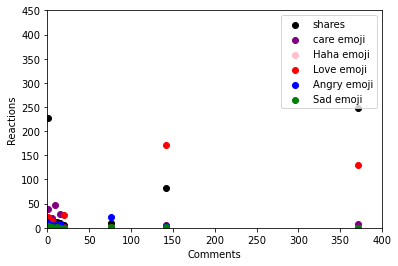

In [45]:
results.reset_index()
plt.xlim(0,400)
plt.ylim(0,450)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


In [46]:
#Topic Modeling
#Create the Dictionary and Corpus needed for Topic Modeling


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]
#Buiding the Topic Model

[[(0, 1), (1, 1)]]


[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]

In [47]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [48]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.074*"national" + 0.056*"color" + 0.038*"vulnerable" + 0.035*"side" + '
  '0.029*"america" + 0.017*"country" + 0.015*"total" + 0.015*"unacceptable" + '
  '0.015*"totally" + 0.015*"alllivesmatter"'),
 (1,
  '0.134*"familia" + 0.045*"really" + 0.008*"sen" + 0.008*"mijente" + '
  '0.008*"michelle" + 0.008*"luchar" + 0.008*"arrests" + 0.001*"votar" + '
  '0.001*"gujral" + 0.001*"historia"'),
 (2,
  '0.122*"political" + 0.057*"america" + 0.055*"medio" + 0.042*"eligible" + '
  '0.031*"provide" + 0.030*"make" + 0.030*"able" + 0.030*"states" + '
  '0.028*"congressional" + 0.027*"race"'),
 (3,
  '0.132*"border" + 0.058*"dangerous" + 0.051*"criminal" + 0.032*"launched" + '
  '0.025*"garcia" + 0.020*"patrol" + 0.007*"michelle" + 0.007*"notar" + '
  '0.001*"decir" + 0.001*"graduates"'),
 (4,
  '0.059*"democrats" + 0.039*"law" + 0.034*"votar" + 0.033*"order" + '
  '0.030*"ideo" + 0.029*"also" + 0.025*"legal" + 0.022*"choose" + 0.022*"true" '
  '+ 0.020*"composed"'),
 (5,
  '0.001*"georgia"

In [49]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.121526447196766

Coherence Score:  0.4611715380025886


In [50]:
#Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.351769 -0.125395       1        1  27.190165
16    -0.205601  0.117605       2        1  15.173465
4     -0.043908  0.278780       3        1  11.126980
17    -0.042228 -0.148158       4        1   8.991482
2     -0.073111  0.052513       5        1   8.614964
6     -0.160243 -0.024204       6        1   8.166511
10     0.087156 -0.051087       7        1   3.013136
12     0.069745  0.038347       8        1   2.778425
11     0.088950 -0.048121       9        1   2.480825
13     0.046686  0.071412      10        1   2.214510
0      0.016239  0.010632      11        1   1.969931
3      0.070311 -0.030484      12        1   1.833841
1      0.066578 -0.012947      13        1   1.447940
19     0.053401  0.017686      14        1   1.376454
14     0.069394 -0.026532      15        1   1.093706
7      0.068561 -0.033713      16        1   0.817806
18     0.061599 -0.022552      17        1   0.570259
8      0.061998 -0.022690      18        1   0.492191
9      0.063635 -0.023811      19        1   0.460481
5      0.052606 -0.017282      20        1   0.186931, topic_info=              Term        Freq       Total Category  logprob  loglift
18           trump  305.000000  305.000000  Default  30.0000  30.0000
52            also   34.000000   34.000000  Default  29.0000  29.0000
118      political   34.000000   34.000000  Default  28.0000  28.0000
15           votar   34.000000   34.000000  Default  27.0000  27.0000
114       director   16.000000   16.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
400  congressional    0.005137    8.396621  Topic20  -7.0716  -1.1170
399       assaults    0.005137    2.295920  Topic20  -7.0716   0.1797
398      universal    0.005137    5.178673  Topic20  -7.0716  -0.6337
397        support    0.005137    6.908260  Topic20  -7.0716  -0.9219
396          sites    0.005137    5.178673  Topic20  -7.0716  -0.6337

[849 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
373       2  0.965498         abide
63        4  0.101533          able
63        5  0.812263          able
302       5  0.734858       account
374       2  0.863173   accountable
...     ...       ...           ...
15       10  0.172416         votar
320       2  0.662758    vulnerable
320      11  0.265103    vulnerable
25        1  0.942855  want_someone
466       7  0.830942         words

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 17, 5, 18, 3, 7, 11, 13, 12, 14, 1, 4, 2, 20, 15, 8, 19, 9, 10, 6])

## Building LDA Mallet Model

In [51]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [52]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('director', 0.08088235294117647),
   ('decir', 0.07352941176470588),
   ('personar', 0.03676470588235294),
   ('latino', 0.029411764705882353),
   ('solicitante', 0.029411764705882353),
   ('compartir', 0.022058823529411766),
   ('virtual', 0.022058823529411766),
   ('ilegal', 0.022058823529411766),
   ('encontrar', 0.022058823529411766),
   ('unir', 0.022058823529411766)]),
 (19,
  [('ideo', 0.08176100628930817),
   ('choose', 0.07547169811320754),
   ('country', 0.06918238993710692),
   ('order', 0.05660377358490566),
   ('true', 0.0440251572327044),
   ('equally_irrefutable', 0.03773584905660377),
   ('composed', 0.03773584905660377),
   ('decidir', 0.031446540880503145),
   ('proposed', 0.031446540880503145),
   ('propose', 0.025157232704402517)]),
 (10,
  [('criminal', 0.09090909090909091),
   ('race', 0.07792207792207792),
   ('armar', 0.05844155844155844),
   ('states', 0.05844155844155844),
   ('control', 0.045454545454545456),
   ('dangerous', 0.03896103896103896),
  

## Finding the optimal number of topics for LDA

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [54]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

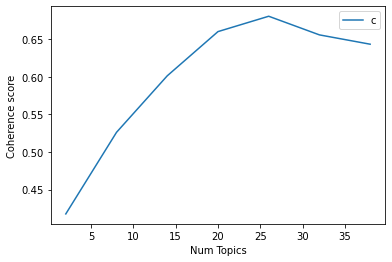

In [55]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4176
Num Topics = 8  has Coherence Value of 0.5262
Num Topics = 14  has Coherence Value of 0.6014
Num Topics = 20  has Coherence Value of 0.6603
Num Topics = 26  has Coherence Value of 0.6807
Num Topics = 32  has Coherence Value of 0.6559
Num Topics = 38  has Coherence Value of 0.6435


In [57]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.083*"ideo" + 0.071*"choose" + 0.038*"equally_irrefutable" + '
  '0.038*"composed" + 0.038*"national" + 0.038*"true" + 0.032*"proposed" + '
  '0.032*"decidir" + 0.026*"propose" + 0.026*"fundamental"'),
 (1,
  '0.154*"democrats" + 0.128*"legal" + 0.081*"criminal" + 0.074*"law" + '
  '0.040*"constitutional" + 0.034*"indivisible" + 0.034*"crimes" + '
  '0.034*"dtos" + 0.027*"mff" + 0.020*"soro"'),
 (2,
  '0.095*"president" + 0.071*"medio" + 0.056*"sexual" + 0.040*"roundtable" + '
  '0.040*"living" + 0.032*"social" + 0.032*"senator" + 0.032*"profits" + '
  '0.024*"airports" + 0.024*"processes"'),
 (3,
  '0.153*"border" + 0.093*"states" + 0.059*"color" + 0.034*"pay" + '
  '0.034*"real" + 0.025*"eligible" + 0.025*"close" + 0.025*"central" + '
  '0.017*"doesnt" + 0.017*"power"'),
 (4,
  '0.068*"national" + 0.047*"social" + 0.041*"numerous" + 0.041*"dangerous" + '
  '0.034*"degree" + 0.034*"congressional" + 0.027*"3" + 0.027*"educational" + '
  '0.027*"annual" + 0.027*"arts"'),
 (5,
 

## Finding the dominant topic in each sentence

In [58]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.0673,"democrats, legal, criminal, law, constitutiona...","""President Donald J. Trump is bringing back th..."
1,1,14.0,0.0643,"citizen, originally, brazil, first_presidentia...","President Donald J. Trump: ""Our Hispanic-Ameri..."
2,2,14.0,0.1038,"citizen, originally, brazil, first_presidentia...","Since 2016, Julio de Lima Silva, originally fr..."
3,3,0.0,0.0500,"ideo, choose, equally_irrefutable, composed, n...","There you go! That man lies, lies, lies."
4,4,12.0,0.0744,"director, nurse, control, county, georgia, div...","“ I raise a Hallelujah, in the presence of my ..."
5,5,14.0,0.1339,"citizen, originally, brazil, first_presidentia...","Since 2016, Julio de Lima Silva, originally f..."
6,6,0.0,0.0500,"ideo, choose, equally_irrefutable, composed, n...",Tech leaders supporting Biden.
7,7,19.0,0.2637,"trump, talk, dictator, want_someone, cages, ag...",Still love my democrat friends and family but....
8,8,3.0,0.0813,"border, states, color, pay, real, eligible, cl...","Lol, what a joke. Central American migrants wa..."
9,9,10.0,0.0730,"trump, illegal, debatir, alien, chose, factor,...",❤️❤️❤️ President Trump on Friday declared Nov....


## Find the most representative document for each topic

In [59]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4234,"ideo, choose, equally_irrefutable, composed, national, true, proposed, decidir, propose, fundamental",Do you know Alexander Hamilton? Would you like to know some of his best phrases? Well here in The Alternative we will bring you your own words and our opinions. Read them carefully... ′′ It is an undisputed truth that the whole people of each country sincerely desire their prosperity; but it is equally irrefutable that it does not possess the discernment and stability necessary for a systemat...
1,1.0,0.3515,"democrats, legal, criminal, law, constitutional, indivisible, crimes, dtos, mff, soro","It is no exaggeration to say that criminals want Democrats in power. And vice versa. Criminals are now a major voting and power base of the Democrat Party. As in the old Mafia days, in classic tit for tat, Democrats ignore crimes and criminals, and criminals support Democrats running for office. But the matter is more complicated than you might think. According to our law enforcement sources,..."
2,2.0,0.2199,"president, medio, sexual, roundtable, living, social, senator, profits, airports, processes","**IF THIS DOES NOT SCARE YOU, THEN WE ARE IN WORSE TROUBLE THAN YOU KNOW!!!** CHARLES KRAUTHAMMER (An Pulitzer Prize columnist.) Seven months BEFORE HIS DEATH on 2017, He wrote the following: “I do not understand how living in a country with its democracy established over 200 years ago, and now, for the first time in history, suddenly we have a former president, Barack Obama, set up a group ca..."
3,3.0,0.1516,"border, states, color, pay, real, eligible, close, central, doesnt, power","Lets recall Newsome. Discrimination has to stop. Discrimination against other races is real. Renting an apartment depends on who and where you are Emily DeRuy PUBLISHED: February 20, 2020 at 6:00 a.m. | UPDATED: September 15, 2020 at 5:29 p.m. Categories:Business, California News, Housing, Latest Headlines, News, Real Estate Some people have an easier time finding an apartment than others, and..."
4,4.0,0.3735,"national, social, numerous, dangerous, degree, congressional, 3, educational, annual, arts","Breaking Campaign News. Jeffi Grigenti has received the Endorsement of Bishop Juan Carlos Mendez and Churches In Action of Los Angeles. ""Bishop Juan Carlos Mendez, was born in Guatemala and migrated to the United States of America in 1976 to Los Angeles, California, where he resides and has been locally engaged as an advocate for social justice for over 30 years. As founder and president of C..."
5,5.0,0.2926,"decir, familia, personar, latinosfortrump, asilar, apoyar, solicitante, garcia, compartir, indio","Many Latino voters in the state said they are hesitant to vote for Biden because of his role in the Obama administration, which ordered more deportations than any other administration. During its eight years in office, the administration deported more than three million people. García said he shares that same disappointment with Iowa immigrants, but reminded voters Biden was vice president at ..."
6,6.0,0.2284,"votar, hear, deal, doctor, local, rest, cd, areas, included, post","THIS JUST IN: The Republican National Hispanic Assembly of Florida is proud to announce our endorsement and unwavering support of Dr. Leo Valentín for Congress!! We’re committed to helping him Take Back CD7. Hispanics are sick of Stephanie Murphy. Sickened by divisive impeachment votes, sickened by illegal immigration, sickened by the job killing green new deal, her support for Joe Biden’s rac..."
7,7.0,0.4483,"race, immigration, global, federal, regional, create, individual, usar, vulnerable, crisis",(Below borrowed from a friend) I’ve heard from people that they want a reason to vote FOR Biden beyond that hes not Trump. Here are 100 reasons to vote for #JoeBiden that dont mention Trump. 1.) $15.00 federal minimum wage 2.) Reinstate DACA – allowing new applicants to apply 3.) 12 Weeks federal paid family leave 4.) Universa

In [60]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [61]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"democrats, legal, criminal, law, constitutional, indivisible, crimes, dtos, mff, soro",35.0,0.1394
1.0,14.0,"citizen, originally, brazil, first_presidential, federalist_latinos, armar, latinosfortrump, defender, jaguar, ignoramuses",17.0,0.0677
2.0,14.0,"citizen, originally, brazil, first_presidential, federalist_latinos, armar, latinosfortrump, defender, jaguar, ignoramuses",12.0,0.0478
3.0,0.0,"ideo, choose, equally_irrefutable, composed, national, true, proposed, decidir, propose, fundamental",13.0,0.0518
4.0,12.0,"director, nurse, control, county, georgia, dividir, irwin, votar, chirlar, votante",5.0,0.0199
5.0,14.0,"citizen, originally, brazil, first_presidential, federalist_latinos, armar, latinosfortrump, defender, jaguar, ignoramuses",3.0,0.0120
6.0,0.0,"ideo, choose, equally_irrefutable, composed, national, true, proposed, decidir, propose, fundamental",12.0,0.0478
7.0,19.0,"trump, talk, dictator, want_someone, cages, agree, pastar, america, fairfax, ignorar",8.0,0.0319
8.0,3.0,"border, states, color, pay, real, eligible, close, central, doesnt, power",3.0,0.0120
9.0,10.0,"trump, illegal, debatir, alien, chose, factor, needed, issue, college, stable",14.0,0.0558
